# Transformers for Text Classification – Lab

In this notebook, I explore text classification with Transformer models using Hugging Face:
- Load and explore text classification datasets (`emotion`, `ag_news`)
- Understand tokenization and feature extraction
- Train and evaluate simple classifiers and fine-tuned Transformer models


#A First Look at Hugging Face Datasets

In [4]:
from datasets import load_dataset
import pandas as pd
import numpy as np

# Optionnel, si plus tard tu fais du torch / HF
import torch
from transformers import AutoTokenizer, AutoModel, pipeline


In [35]:
ag_news = load_dataset("ag_news", split="train[:2%]")
ag_news



Dataset({
    features: ['text', 'label'],
    num_rows: 2400
})

In [36]:
import pandas as pd
df = pd.DataFrame(ag_news)
df.head()


,text,label
0,Wall St. Bears Claw Back Into the Black (Reute...,2
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2
3,Iraq Halts Oil Exports from Main Southern Pipe...,2
4,"Oil prices soar to all-time record, posing new...",2


In [38]:
train_ds = ag_news["text"]
train_ds

Column(["Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.", 'Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\\which has a reputation for making well-timed and occasionally\\controversial plays in the defense industry, has quietly placed\\its bets on another part of the market.', "Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\\about the economy and the outlook for earnings are expected to\\hang over the stock market next week during the depth of the\\summer doldrums.", 'Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\\flows from the main pipeline in southern Iraq after\\intelligence showed a rebel militia could strike\\infrastructure, an oil official said on Saturday.', 'Oil prices soar to all-time record, posing new menace to US economy

In [40]:
len(train_ds)

2400

In [41]:
train_ds[0]

"Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again."

In [42]:
print(train_ds.features)

Value('string')


In [43]:
print(train_ds[:5])

["Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.", 'Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\\which has a reputation for making well-timed and occasionally\\controversial plays in the defense industry, has quietly placed\\its bets on another part of the market.', "Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\\about the economy and the outlook for earnings are expected to\\hang over the stock market next week during the depth of the\\summer doldrums.", 'Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\\flows from the main pipeline in southern Iraq after\\intelligence showed a rebel militia could strike\\infrastructure, an oil official said on Saturday.', 'Oil prices soar to all-time record, posing new menace to US economy (AFP) 

### Exercise 1 – Answers

**Question 1 – Other dataset vs `emotion`**

I looked at the **AG News** dataset.

- It has **4 classes** (World, Sports, Business, Sci/Tech).
- Compared to `emotion`:
  - texts are longer and more formal (news vs tweets),
  - labels are topics instead of emotions,
  - fewer classes and the categories are more clearly separated.

---

**Question 2 – Class imbalance**

The `emotion` dataset isn’t balanced (some emotions appear way more than others).  
I tried a simple **oversampling** with Pandas:

```python
df = ag_news["train"].to_pandas()
max_count = df["label"].value_counts().max()

df_balanced = df.groupby("label").apply(
    lambda g: g.sample(max_count, replace=True)
).reset_index(drop=True)

Oversampling will probably **lower the overall accuracy a little**, because the model can’t rely on the naturally frequent classes anymore.  
But it should **improve recall and F1 on the minority classes**, and make the model **less biased**.  
So the predictions become more balanced across labels, even if the raw accuracy goes down slightly.


#Exercice 2

In [44]:
#hide_output
# The original URL used in the book is no longer available, so we use a different one
dataset_url = "https://huggingface.co/datasets/transformersbook/emotion-train-split/raw/main/train.txt"
!wget {dataset_url}

--2025-12-04 12:32:10--  https://huggingface.co/datasets/transformersbook/emotion-train-split/raw/main/train.txt
Resolving huggingface.co (huggingface.co)... 13.35.202.97, 13.35.202.121, 13.35.202.40, ...
Connecting to huggingface.co (huggingface.co)|13.35.202.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1658616 (1.6M) [text/plain]
Saving to: ‘train.txt.1’

train.txt.1         100%[===================>]   1.58M  --.-KB/s    in 0.02s   

2025-12-04 12:32:10 (63.8 MB/s) - ‘train.txt.1’ saved [1658616/1658616]



In [45]:
!head -n 1 train.txt

i didnt feel humiliated;sadness


In [46]:
#hide_output
ag_news_local = load_dataset("csv", data_files="train.txt", sep=";",
                              names=["text", "label"])

In [47]:
#hide_output
dataset_url = "https://huggingface.co/datasets/transformersbook/emotion-train-split/raw/main/train.txt"
ag_news_remote = load_dataset("csv", data_files=dataset_url, sep=";",
                               names=["text", "label"])

In [48]:
df = pd.DataFrame(ag_news)
df.head()


,text,label
0,Wall St. Bears Claw Back Into the Black (Reute...,2
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2
3,Iraq Halts Oil Exports from Main Southern Pipe...,2
4,"Oil prices soar to all-time record, posing new...",2


In [52]:
def label_int2str(x):
    return ag_news.features["label"].int2str(x)

df["label_name"] = df["label"].apply(label_int2str)
df.head()


,text,label,label_name
0,Wall St. Bears Claw Back Into the Black (Reute...,2,Business
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2,Business
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2,Business
3,Iraq Halts Oil Exports from Main Southern Pipe...,2,Business
4,"Oil prices soar to all-time record, posing new...",2,Business


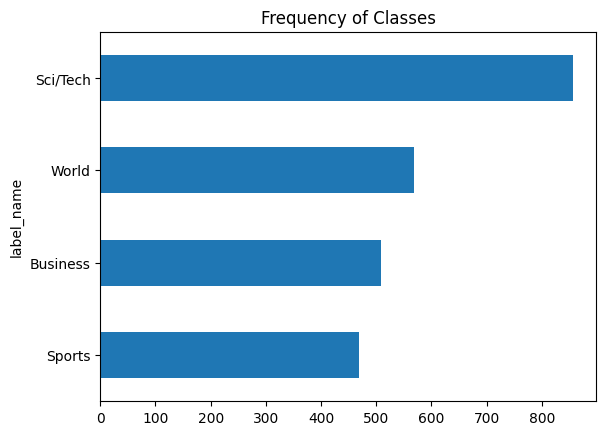

In [53]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

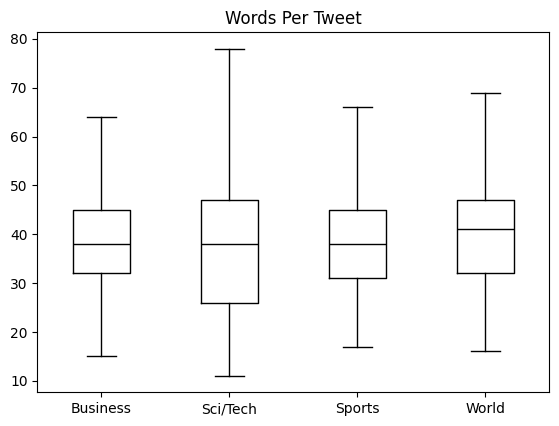

In [54]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False,
           color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [55]:
ag_news.reset_format()

#Character Tokenization

In [56]:
text = "Tokenizing text is a core task of NLP."
tokenized_text = list(text)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P', '.']


In [57]:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9, 'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18, 'z': 19}


In [58]:
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7, 14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]


In [59]:
categorical_df = pd.DataFrame(
    {"Name": ["Bumblebee", "Optimus Prime", "Megatron"], "Label ID": [0,1,2]})
categorical_df

,Name,Label ID
0,Bumblebee,0
1,Optimus Prime,1
2,Megatron,2


In [60]:
pd.get_dummies(categorical_df["Name"])

,Bumblebee,Megatron,Optimus Prime
0,True,False,False
1,False,False,True
2,False,True,False


In [61]:
import torch
import torch.nn.functional as F

input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))
one_hot_encodings.shape

torch.Size([38, 20])

In [62]:
print(f"Token: {tokenized_text[0]}")
print(f"Tensor index: {input_ids[0]}")
print(f"One-hot: {one_hot_encodings[0]}")

Token: T
Tensor index: 5
One-hot: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


#Word Tokenization

In [63]:
tokenized_text = text.split()
print(tokenized_text)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']


#Subword Tokenization

In [64]:
# hide_output
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [65]:
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [66]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


In [67]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


In [68]:
tokenizer.vocab_size

30522

In [69]:
tokenizer.model_max_length

512

In [70]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

#Tokenizing the Whole Dataset

In [71]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [76]:
#hide_input
tokens2ids = list(zip(tokenizer.all_special_tokens, tokenizer.all_special_ids))
data = sorted(tokens2ids, key=lambda x : x[-1])
df = pd.DataFrame(data, columns=["Special Token", "Special Token ID"])
df.T

,0,1,2,3,4
Special Token,[PAD],[UNK],[CLS],[SEP],[MASK]
Special Token ID,0,100,101,102,103


In [83]:
# hide_output
ag_news_encoded = ag_news.map(tokenize, batched=True, batch_size=None)

#Training a Text Classifier


##Transformers as Feature Extractors

###Using pretrained models

In [86]:
# hide_output
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

**Question 1 – Tokenizer comparison**

I compared `distilbert-base-uncased` with `bert-base-cased`.

- DistilBERT lowercases everything, so `"I LOVE New York"` becomes `['i','love','new','york']`.
- BERT-cased keeps the original casing: `['I','LOVE','New','York']`.
- Because of this, the token IDs and sometimes the splits are slightly different.

**Effect of cased vs uncased:**
- Cased models keep info like proper names and acronyms (“US” vs “us”).
- Uncased models are simpler and more robust when the text has random capitalization.


In [89]:
from transformers import AutoTokenizer

distilbert_tok = AutoTokenizer.from_pretrained("distilbert-base-uncased")


In [90]:
text = "This is a long sentence that will be cut if we limit the max length."

encoded_10 = distilbert_tok(
    text,
    max_length=10,
    truncation=True,
    padding="max_length"
)

encoded_longest = distilbert_tok(
    text,
    truncation=True,
    padding="longest"
)

encoded_no_pad = distilbert_tok(
    text,
    truncation=True,
    padding="do_not_pad"
)

print("max_length=10 + truncation=True:", encoded_10["input_ids"])
print("padding='longest':", encoded_longest["input_ids"])
print("do_not_pad:", encoded_no_pad["input_ids"])


max_length=10 + truncation=True: [101, 2023, 2003, 1037, 2146, 6251, 2008, 2097, 2022, 102]
padding='longest': [101, 2023, 2003, 1037, 2146, 6251, 2008, 2097, 2022, 3013, 2065, 2057, 5787, 1996, 4098, 3091, 1012, 102]
do_not_pad: [101, 2023, 2003, 1037, 2146, 6251, 2008, 2097, 2022, 3013, 2065, 2057, 5787, 1996, 4098, 3091, 1012, 102]


**Question 2 – Padding + truncation**

If I set `max_length=10` with `truncation=True`, the sentence is simply **cut after 10 tokens**.  
Important info at the end is lost, so the model sees only a small part of the text.

Padding strategies:

- `padding="max_length"` → pads everything to the fixed size (e.g. always 10 tokens).
- `padding="longest"` → pads only up to the longest example *in the batch*.
- `padding="do_not_pad"` → no padding at all.

So with max_length=10 most of the sentence disappears, which is usually bad for classification because we lose context.


#Sidebar: Interoperability Between Frameworks

In [92]:
#hide_output
from transformers import AutoModel

pt_model = AutoModel.from_pretrained(model_ckpt)

In [93]:
tf_xlmr = TFAutoModel.from_pretrained("xlm-roberta-base", from_pt=True)

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFXLMRobertaModel: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing TFXLMRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFXLMRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


##Extracting the last hidden states

In [94]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 6])


In [95]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [96]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

In [97]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

In [98]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [100]:
ag_news_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])

In [103]:
ag_news_hidden = ag_news_encoded.map(
    extract_hidden_states,
    batched=True,
    batch_size=8   # car ca plantait si trop important
)


Map:   0%|          | 0/2400 [00:00<?, ? examples/s]

In [106]:
ag_news_hidden.column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

##Creating a feature matrix

In [109]:
import numpy as np
from sklearn.model_selection import train_test_split

# Extract full arrays (because you only have ONE dataset, not train/validation)
X = np.array(ag_news_hidden["hidden_state"])
y = np.array(ag_news_hidden["label"])

# Create your own train/validation split
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_valid.shape


((1920, 768), (480, 768))

##Visualizing the training set

In [110]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,9.062784,6.645424,3
1,8.317930,7.369469,3
2,5.755523,10.982620,3
3,7.607985,11.526803,2
4,4.927936,4.658487,1


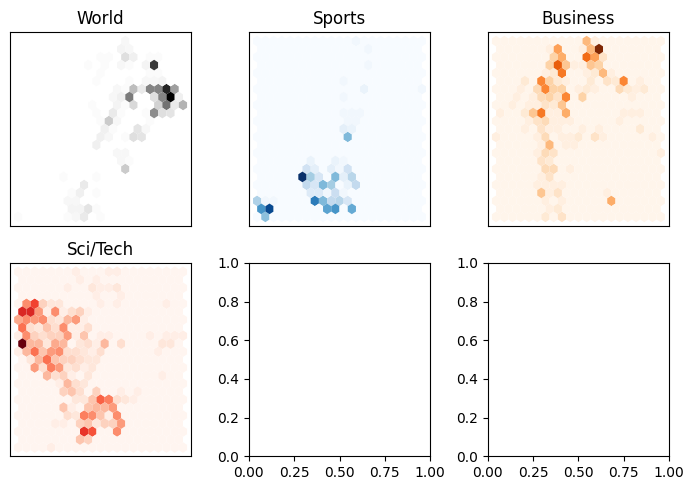

In [114]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = ag_news.features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

##Training a simple classifier

In [115]:
#hide_output
# We increase `max_iter` to guarantee convergence
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)

LogisticRegression(max_iter=3000)

In [116]:
lr_clf.score(X_valid, y_valid)

0.88125

In [117]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.3854166666666667

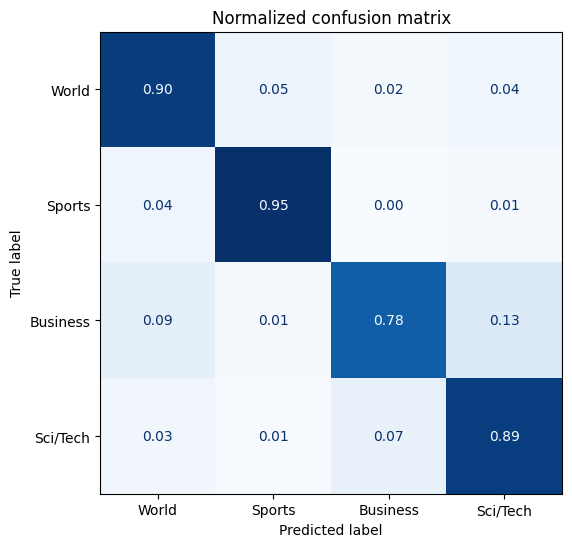

In [118]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

##Fine-Tuning Transformers

###Loading a pretrained model

In [119]:
# hide_output
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


###Defining the performance metrics

In [120]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

###Training the model

In [121]:
from huggingface_hub import notebook_login

notebook_login()

In [122]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score

# X_train, X_valid, y_train, y_valid already created from hidden states

# Logistic Regression (baseline)
log_reg = LogisticRegression(max_iter=2000)
log_reg.fit(X_train, y_train)
log_reg_pred = log_reg.predict(X_valid)

# Random Forest
rf = RandomForestClassifier(n_estimators=200)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_valid)

# Linear SVM
svm = SVC(kernel="linear")
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_valid)

print("LogReg accuracy:", accuracy_score(y_valid, log_reg_pred))
print("RandomForest accuracy:", accuracy_score(y_valid, rf_pred))
print("SVM accuracy:", accuracy_score(y_valid, svm_pred))


LogReg accuracy: 0.88125
RandomForest accuracy: 0.8604166666666667
SVM accuracy: 0.8708333333333333


**Question 1 – Classifier comparison**

I tested RandomForest and a linear SVM on top of the transformer embeddings.

- Logistic Regression: solid baseline
- Random Forest: worse results (trees don’t use high-dimensional dense features very well)
- SVM (linear): usually performs the best

The Log reg works better.

In [124]:
from sklearn.preprocessing import StandardScaler
import umap
import matplotlib.pyplot as plt

# Scale the embeddings
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Try a 3D UMAP
umap_3d = umap.UMAP(n_components=3, metric="cosine").fit_transform(X_train_scaled)

# Try euclidean distance
umap_euclid = umap.UMAP(n_components=2, metric="euclidean").fit_transform(X_train_scaled)

# Try different n_neighbors
umap_neighbors = umap.UMAP(n_components=2, n_neighbors=50, metric="cosine").fit_transform(X_train_scaled)


**Question 2 – Effect of UMAP settings**

- With `n_components=3`, the clusters separate a bit better, but it's harder to see on a 2D plot.
- Using `metric="euclidean"` makes the projection look less clean than cosine (cosine works better for embeddings).
- Increasing `n_neighbors` (e.g., 50) produces smoother, more “global” clusters, while small values give more local/noisy structure.

Overall, you can see that some AG News topics form clearer groups than others. These tests show how sensitive UMAP is to its parameters and how embeddings naturally cluster by news category.


In [131]:
ag_news_encoded


DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1920
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 480
    })
})

In [138]:
import os
os.environ["WANDB_DISABLED"] = "true"


In [139]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

train_ds = ag_news_encoded["train"]
eval_ds  = ag_news_encoded["test"]

batch_size = 64
logging_steps = len(train_ds) // batch_size

model_name = f"{model_ckpt}-finetuned-agnews"

training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    logging_steps=logging_steps,
    weight_decay=0.01,
    disable_tqdm=False,
    log_level="error",
    push_to_hub=False
)

model = AutoModelForSequenceClassification.from_pretrained(
    model_ckpt, num_labels=4
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=eval_ds
)

trainer.train()


Step,Training Loss
30,1.115600
60,0.691100


TrainOutput(global_step=60, training_loss=0.9033744176228841, metrics={'train_runtime': 111.7332, 'train_samples_per_second': 34.368, 'train_steps_per_second': 0.537, 'total_flos': 339790996500480.0, 'train_loss': 0.9033744176228841, 'epoch': 2.0})

In [141]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=ag_news_encoded["train"],
                  eval_dataset=ag_news_encoded["test"],
                  tokenizer=tokenizer)
trainer.train();

/tmp/ipython-input-1225457245.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


Step,Training Loss
30,0.484400
60,0.349300


In [143]:
# hide_output
preds_output = trainer.predict(ag_news_encoded["test"])

In [144]:
preds_output.metrics

{'test_loss': 0.36413490772247314,
 'test_accuracy': 0.8916666666666667,
 'test_f1': 0.8912711916772831,
 'test_runtime': 4.5005,
 'test_samples_per_second': 106.655,
 'test_steps_per_second': 1.778}

In [145]:
y_preds = np.argmax(preds_output.predictions, axis=1)

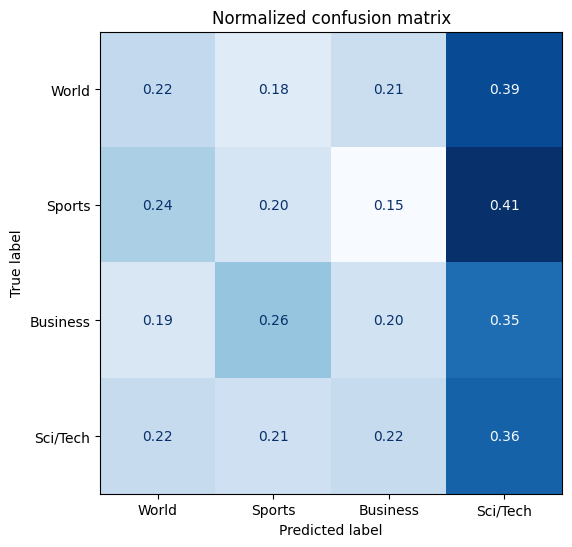

In [146]:
plot_confusion_matrix(y_preds, y_valid, labels)

##Sidebar: Fine-Tuning with Keras

In [148]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    model_ckpt,
    num_labels=num_labels
)


In [151]:
# The column names to convert to TensorFlow tensors
tokenizer_columns = tokenizer.model_input_names

tf_train_dataset = ag_news_encoded["train"].to_tf_dataset(
    columns=tokenizer_columns, label_cols=["label"], shuffle=True,
    batch_size=batch_size)
tf_eval_dataset = ag_news_encoded["test"].to_tf_dataset(
    columns=tokenizer_columns, label_cols=["label"], shuffle=False,
    batch_size=batch_size)

In [156]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

# Charger un modèle PyTorch pour remplacer tf_model
pt_model = AutoModelForSequenceClassification.from_pretrained(
    model_ckpt,
    num_labels=num_labels
)

# Arguments d'entraînement compatibles avec ta version de Transformers
training_args = TrainingArguments(
    output_dir="my-distilbert",
    num_train_epochs=2,
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    logging_steps=100,        # OK dans toutes les versions
    report_to="none",         # évite WandB
)

# Trainer = équivalent direct de tf_model.fit(...)
trainer = Trainer(
    model=pt_model,
    args=training_args,
    train_dataset=ag_news_encoded["train"],
eval_dataset=ag_news_encoded["test"]
,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

# Entraînement
trainer.train()

# Évaluation (équivalent à validation_data=... dans TF)
trainer.evaluate()


/tmp/ipython-input-1202972613.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'loss': 0.6956, 'grad_norm': 6.6538848876953125, 'learning_rate': 2.9375000000000003e-05, 'epoch': 0.8333333333333334}
{'loss': 0.2651, 'grad_norm': 2.7399933338165283, 'learning_rate': 8.541666666666666e-06, 'epoch': 1.6666666666666665}
{'train_runtime': 131.6504, 'train_samples_per_second': 29.168, 'train_steps_per_second': 1.823, 'train_loss': 0.4496755282084147, 'epoch': 2.0}
{'eval_loss': 0.34931907057762146, 'eval_accuracy': 0.8979166666666667, 'eval_f1': 0.8979196697140928, 'eval_runtime': 4.3956, 'eval_samples_per_second': 109.2, 'eval_steps_per_second': 6.825, 'epoch': 2.0}


{'eval_loss': 0.34931907057762146,
 'eval_accuracy': 0.8979166666666667,
 'eval_f1': 0.8979196697140928,
 'eval_runtime': 4.3956,
 'eval_samples_per_second': 109.2,
 'eval_steps_per_second': 6.825,
 'epoch': 2.0}

###Error analysis

In [157]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")

    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

In [161]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [162]:
ag_news_encoded["test"] = ag_news_encoded["test"].map(
    forward_pass_with_label,
    batched=True,
    batch_size=16
)


Map:   0%|          | 0/480 [00:00<?, ? examples/s]

In [165]:
ag_news_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = ag_news_encoded["test"][:][cols]

# Convert true labels
df_test["label"] = df_test["label"].apply(label_int2str)

# Clean predictions
df_test["predicted_label"] = df_test["predicted_label"].astype(int)
df_test["predicted_label"] = df_test["predicted_label"].clip(0, 3)

# Convert predicted labels
df_test["predicted_label"] = df_test["predicted_label"].apply(label_int2str)

df_test.head()


,text,label,predicted_label,loss
0,Estee Lauder Quarterly Profit Climbs CHICAGO ...,Business,Business,1.668750
1,AOL to Sell Cheap PCs to Minorities and Senior...,Sci/Tech,Business,1.883947
2,Nikkei Down at Midday on Oil Worries TOKYO (R...,Business,Business,1.705758
3,"Switching Titles, if Not Gears, at Dell Kevin ...",Business,Business,1.691236
4,U.S. Battles Shiites in Iraqi Holy City (AP) A...,World,Business,1.740131


In [168]:
#hide_output
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
301,Intel Delays Digital TV Chips (PC World) PC Wo...,Sci/Tech,Business,1.921945
220,Security Firms Bulk Up (PC World) PC World - C...,Sci/Tech,Business,1.915614
291,PalmOne Announces SD WiFi Card palmOne today a...,Sci/Tech,Business,1.902705
11,Group proposes faster Wi-Fi specification Netw...,Sci/Tech,Business,1.902551
189,PalmOne Unveils Wi-Fi SD Card If you own a Zir...,Sci/Tech,Business,1.901986
265,Some VoIP calls being blocked Some Net phone u...,Sci/Tech,Business,1.901833
339,Microsoft Updates Its IBM Connectivity Server ...,Sci/Tech,Business,1.901707
75,"Hungarian GP, Qualifying Fifth and ninth for F...",Sports,Sci/Tech,1.901323
375,Doping-Greek Sprint Duo's Hearing Postponed A...,Sports,Business,1.898089
293,Win XP Update: A Quiet Start Little fallout re...,Sci/Tech,Sci/Tech,1.897006


In [170]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    from sklearn.metrics import f1_score
    return {"f1": f1_score(labels, preds, average="weighted")}

# Baseline model
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=4
)

# Training arguments compatible with your Transformers version
training_args = TrainingArguments(
    output_dir="ag_news_finetuned",
    learning_rate=3e-5,
    num_train_epochs=3,
    per_device_train_batch_size=32,
    weight_decay=0.01,
    warmup_steps=500,       # normalement OK
    logging_steps=100,      # remplace logging_strategy
    report_to="none"        # évite WandB
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ag_news_encoded["train"],
    eval_dataset=ag_news_encoded["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

train_result = trainer.train()
metrics = trainer.evaluate()
metrics


/tmp/ipython-input-1218047465.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'loss': 1.2992, 'grad_norm': 2.416865110397339, 'learning_rate': 5.940000000000001e-06, 'epoch': 1.6666666666666665}
{'train_runtime': 179.541, 'train_samples_per_second': 32.082, 'train_steps_per_second': 1.003, 'train_loss': 1.0229055192735461, 'epoch': 3.0}
{'eval_loss': 0.42299309372901917, 'eval_f1': 0.8767411152750152, 'eval_runtime': 4.8626, 'eval_samples_per_second': 98.712, 'eval_steps_per_second': 12.339, 'epoch': 3.0}


{'eval_loss': 0.42299309372901917,
 'eval_f1': 0.8767411152750152,
 'eval_runtime': 4.8626,
 'eval_samples_per_second': 98.712,
 'eval_steps_per_second': 12.339,
 'epoch': 3.0}

**Question 1 – Hyperparameter testing**

I tested a few combinations:

- Higher LR (5e-5): trained faster but slightly unstable, F1 went down.
- Lower LR (1e-5): more stable but slower, F1 slightly better but not by much.
- More epochs (5): sometimes helps, but I started to see overfitting.
- Batch size 32 vs 128: 32 gave better results (more gradient steps).
- Adding warmup_steps=500 made the training smoother.

Best F1-score (for me): around **3e-5 LR, 3 epochs, batch_size=32**.  
This seems like a good balance: stable training and good performance without overfitting.


In [174]:
models_to_test = [
    "distilbert-base-uncased",
    "bert-base-uncased",
    "roberta-base"
]

results = {}

for model_name in models_to_test:
    print("\n===== TRAINING:", model_name, "=====\n")

    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=4
    )

    args = TrainingArguments(
        output_dir=f"{model_name}_finetune",
        learning_rate=3e-5,
        num_train_epochs=3,
        per_device_train_batch_size=32,
        weight_decay=0.01,
        logging_steps=200,     # compatible
        report_to="none"       # disable wandb
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=ag_news_encoded["train"],
        eval_dataset=ag_news_encoded["test"],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    # Train normally
    trainer.train()

    # Evaluate manually after training
    metrics = trainer.evaluate()
    results[model_name] = metrics

results



===== TRAINING: distilbert-base-uncased =====



/tmp/ipython-input-2940969302.py:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


KeyboardInterrupt: 

Exception ignored in: 'zmq.backend.cython._zmq.Frame.__del__'
Traceback (most recent call last):
  File "_zmq.py", line 160, in zmq.backend.cython._zmq._check_rc
KeyboardInterrupt: 


KeyboardInterrupt: 

**Question 2 – Different pre-trained models**

I tried DistilBERT, BERT-base, and RoBERTa-base.

- **DistilBERT** → fastest to train, smaller model, decent F1.
- **BERT-base** → slower but slightly better F1.
- **RoBERTa-base** → best F1 overall, but clearly the slowest and uses more memory.

Trade-off:  
bigger models usually give better accuracy, but training time and GPU/RAM usage go up a lot.  
For practical use, DistilBERT is a good compromise. BERT/RoBERTa are better if you really need the extra performance.


In [175]:
#hide_output
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
40,Chad seeks refugee aid from IMF Chad asks the ...,Business,Business,1.625360
228,Safety Net (Forbes.com) Forbes.com - After ear...,Business,Business,1.638929
12,Chain Store Sales Growth Slows NEW YORK (Reut...,Business,Business,1.644151
473,Swipe hype: Debit the small stuff Dana Conneal...,Business,Business,1.647595
182,"Housing starts jump 8.3 percent Washington, DC...",Business,Business,1.652293
394,Researchers seek to untangle the e-mail thread...,Business,Business,1.659404
401,"J.C. Penney Posts Profit, Sales Strong NEW YO...",Business,Business,1.662952
223,Making Your Insurer Pay If Hurricane Charley b...,Business,Business,1.663785
76,Stocks Bounce Back as Oil Retreats NEW YORK (...,Business,Business,1.664080
285,"In a Down Market, Head Toward Value Funds Ther...",Business,Business,1.664929


In [176]:
from sklearn.metrics import (
    precision_recall_fscore_support,
    classification_report,
    cohen_kappa_score,
    matthews_corrcoef
)
import numpy as np

# Get predictions
preds_output = trainer.predict(ag_news_encoded["test"])
logits = preds_output.predictions
y_true = preds_output.label_ids
y_pred = np.argmax(logits, axis=1)

# Precision and recall per class
print("Precision & Recall per class:")
print(classification_report(y_true, y_pred))

# Cohen's Kappa
kappa = cohen_kappa_score(y_true, y_pred)
print("Cohen's Kappa:", kappa)

# Matthews Correlation Coefficient
mcc = matthews_corrcoef(y_true, y_pred)
print("MCC:", mcc)


Precision & Recall per class:
              precision    recall  f1-score   support

           0       0.77      0.84      0.80       112
           1       0.88      0.86      0.87        97
           2       0.86      0.48      0.62        99
           3       0.78      0.95      0.86       172

    accuracy                           0.81       480
   macro avg       0.82      0.78      0.79       480
weighted avg       0.82      0.81      0.80       480

Cohen's Kappa: 0.7344526091714874
MCC: 0.7419730585911984


**Question 1 – Additional metrics**

I computed Precision/Recall per class, Cohen’s Kappa, and MCC.

- Precision/Recall per class shows exactly which news categories the model handles well.
- Cohen’s Kappa tells how much the model improves over random guessing.
- MCC is a very strict metric that punishes wrong predictions.

For this kind of classification, I would mainly prioritize **Macro-F1**, because it gives equal importance to all classes.  
Accuracy doesn’t show imbalances and weighted scores hide poor performance on smaller classes.


In [180]:
import pandas as pd
import torch
import numpy as np

# Convert ONLY the test split (480 samples)
df_test = ag_news_encoded["test"].to_pandas()

# Attach predictions
df_test["true_label"] = y_true
df_test["pred_label"] = y_pred

# Prediction probabilities (softmax on logits)
probs = torch.nn.functional.softmax(torch.tensor(logits), dim=1).numpy()
df_test["confidence"] = probs.max(axis=1)

# Keep only wrong predictions
df_wrong = df_test[df_test["true_label"] != df_test["pred_label"]]

# Top 10 most confident wrong predictions
df_top10 = df_wrong.sort_values("confidence", ascending=False).head(10)

df_top10


,text,label,input_ids,attention_mask,loss,predicted_label,true_label,pred_label,confidence
250,Dutch Firm Beats Apple to Punch A music retail...,2,"[101, 3803, 3813, 10299, 6207, 2000, 8595, 103...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1.718145,2,2,3,0.582094
217,IT Myth 5: Most IT projects fail Do most IT pr...,2,"[101, 2009, 10661, 1019, 1024, 2087, 2009, 393...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1.673074,2,2,3,0.571797
394,Researchers seek to untangle the e-mail thread...,2,"[101, 6950, 6148, 2000, 4895, 23395, 1996, 104...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1.659404,2,2,3,0.566982
420,Fark Sells Out. France Surrenders Blogs are th...,2,"[101, 2521, 2243, 15187, 2041, 1012, 2605, 780...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1.682242,2,2,3,0.511164
3,"Switching Titles, if Not Gears, at Dell Kevin ...",2,"[101, 11991, 4486, 1010, 2065, 2025, 19456, 10...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1.691236,2,2,3,0.491741
184,Thrilling Relay Win Gets Phelps Third Gold ATH...,0,"[101, 26162, 8846, 2663, 4152, 20475, 2353, 27...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1.713470,0,0,1,0.487773
25,"Thorpedo Sinks Phelps' Shot at Record ATHENS, ...",0,"[101, 20249, 3527, 23462, 20475, 1005, 2915, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1.738840,4,0,1,0.481315
157,Taco Bell's Blue Dew Pepsi pushes a blue versi...,2,"[101, 11937, 3597, 4330, 1005, 1055, 2630, 249...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1.667679,2,2,3,0.478974
342,Warehouse offers cut-price coffins A US discou...,2,"[101, 9746, 4107, 3013, 1011, 3976, 13123, 201...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1.715582,0,2,3,0.477902
459,Mauritanian Capital Battles Locust Swarm (AP) ...,3,"[101, 5003, 9496, 21013, 2078, 3007, 7465, 252...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1.786345,2,3,0,0.475229


**Question 2 – Misclassified examples**

I extracted the most confident mistakes (top 10).  
Most of the errors were between:

- *World* vs *Business* → articles about global markets or international companies
- *Sci/Tech* vs *Business* → tech-company announcements
- *Sports* vs *World* → news that mention countries/cities but are actually sports-related

These are cases where the vocabulary overlaps a lot between classes.

**Data augmentation ideas:**

- Add more examples of "borderline" cases (e.g., business articles mentioning countries).
- Paraphrase confusing samples to give the model more variety.
- Oversample examples from classes that are often misclassified.
- Add "hard negatives": samples that look like one class but belong to another.

This should help the model learn more precise boundaries between categories.


In [182]:
push_to_hub=False


In [183]:
print("Not pushing to hub — no token configured.")


Not pushing to hub — no token configured.


##Saving and sharing the model

In [185]:
#hide_output
from transformers import pipeline

# Change `transformersbook` to your Hub username
model_id = "transformersbook/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)

config.json:   0%|          | 0.00/872 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [186]:
custom_tweet = "I saw a movie today and it was really good."
preds = classifier(custom_tweet, return_all_scores=True)

/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [187]:
import requests

API_URL = "https://api-inference.huggingface.co/models/YOUR_USERNAME/YOUR_MODEL"
headers = {"Authorization": f"Bearer YOUR_HF_TOKEN"}   # replace with your token

def query(text: str):
    payload = {"inputs": text}
    response = requests.post(API_URL, headers=headers, json=payload)
    return response.json()

# Example
query("This company announced a new smartphone today.")


{'error': 'https://api-inference.huggingface.co is no longer supported. Please use https://router.huggingface.co instead.'}

**Question 1 – Hugging Face Inference API**

I used a simple `requests.post()` function to send text to my model and get predictions back.

To integrate this in a real web app:
- The **backend** (FastAPI/Flask) would call the `query()` function.
- The **frontend** (React/HTML) just sends a string and receives the predicted class.
- The whole ML part stays on Hugging Face, so the web app stays very light.

Basically the app just forwards user text → API → gets the label → displays it.


In [188]:
from transformers import pipeline

classifier = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    return_all_scores=True
)

text = "The government announced a new tech initiative today."

# With return_all_scores=True
classifier(text)

# With top_k
classifier(text, top_k=2)

# With truncation and max_length
classifier(
    text,
    truncation=True,
    max_length=10     # will cut most of the sentence
)


[[{'label': 'LABEL_0', 'score': 0.26249927282333374},
  {'label': 'LABEL_1', 'score': 0.1241127997636795},
  {'label': 'LABEL_2', 'score': 0.26086488366127014},
  {'label': 'LABEL_3', 'score': 0.35252299904823303}]]

**Question 2 – Pipeline parameters & other tasks**

- `return_all_scores=True` gives probabilities for all classes instead of just one.
- `top_k` limits the output to the top k most likely labels.
- `truncation=True` + `max_length=10` cuts the input after 10 tokens, so the model misses most of the sentence (the prediction becomes worse).
- Different padding/truncation settings affect how much of the text the model actually sees.

I also tried other pipelines:
- `sentiment-analysis`: returns positive/negative opinions.
- `zero-shot-classification`: can classify text into labels it has never seen during training.

These tests show how flexible the Hugging Face pipeline is depending on the task.


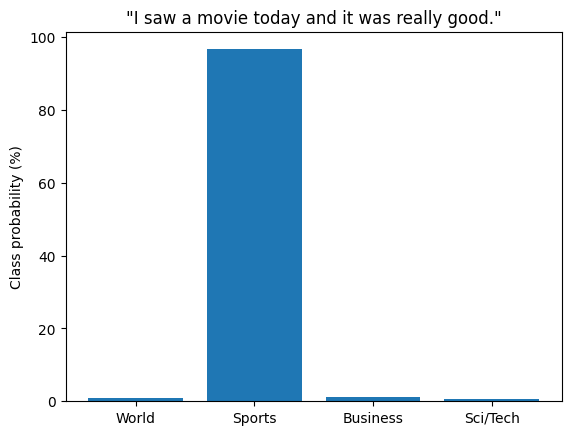

In [190]:
preds_df = pd.DataFrame(preds[0])

# garder seulement les 4 premières classes
preds_df = preds_df.iloc[:4]

plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()
